In [1]:
!pip install geopandas


In [2]:
import descartes
import geopandas as gpd
import numpy as np
from math import radians, cos, sin, asin, sqrt, atan2, pi

In [3]:
sameV = sqlContext.read.parquet("dbfs:/FileStore/tables/Roads/Bay_Area_vertices")
sameE = sqlContext.read.parquet("dbfs:/FileStore/tables/Roads/Bay_Area_edges")
#sameG = GraphFrame(sameV, sameE)

In [4]:
def calc_bounds(center, d):
  """
  * For a given lat-long and distance in kilometers, this function provides the bounds of polygon which is d kilometers away from the centroid in the four cardinal directions
  
  * This is needed to select a subgraph for our analysis
  
  * The value of d is based on the time selected and mode of commute. 
  
    * e.g., for a 30 minute drive time, assumping a max speed of 105 kmph along road, the max, one can travel is 52.5 kms in any direction from the center, so d should be 52.5
    * For 10 mins walk at 5 kmph, d value should be ~ 0.84
  
  """
  RADIUS_OF_EARTH = 6371.0088
  lon_d, lat_d = center
  d = d * sqrt(2)
  poly = []
  for a in range(45, 360, 180): # Bearings of the diagonally opposite bearings 45, 225 (NE, SW)
    
    # Convert the bearing and lat long into radians
    bearing = np.pi / 180.0 * a    
    lat = np.pi * lat_d / 180.0
    lon = np.pi * lon_d / 180.0
    
    new_lat = asin(sin(lat) * cos(d/RADIUS_OF_EARTH) + cos(lat) * sin(d/RADIUS_OF_EARTH) * cos(bearing))
    new_lon = lon + atan2(sin(bearing) * sin(d/RADIUS_OF_EARTH) * cos(lat) ,cos(d/RADIUS_OF_EARTH) - sin(lat) * sin(new_lat))
    new_lat *= 180.0/np.pi
    new_lon *= 180.0/np.pi
    
    poly.append([new_lon, new_lat])
  bounds = list(np.min(np.array(poly), axis = 0))
  bounds.extend(list(np.max(np.array(poly), axis = 0)))
  return bounds

In [5]:
# Test -- Comment out later
def get_bounds(center, time_in_s, mode='drive'):
  """
  mode = {'drive', 'walk'}
  """
  MAX_SPEED_IN_US_KMPH = 128.0
  SPEED_OF_WALK_KMPH = 5.0
  
  if mode == 'walk':
    d = SPEED_OF_WALK_KMPH * time_in_s / 3600.0
  else:
    d = MAX_SPEED_IN_US_KMPH * time_in_s / 3600.0
  bounds = calc_bounds(center, d)
  return bounds

center = [-122.4119388,37.741981]
bounds = get_bounds(center, 1800)
bounds

Out[ 5 ]: 
[-123.13418188331585,
 37.164205073179474,
 -121.67837610051158,
 38.31528097473964]

In [6]:
v2 = sameV.filter("lon > {} and lat > {} and lon <  {} and lat < {}".format(bounds[0], bounds[1], bounds[2], bounds[3]))
e2 = sameE.filter("src_lon > {} and src_lat > {} and src_lon <  {} and src_lat < {}".format(bounds[0], bounds[1], bounds[2], bounds[3]))
#g2 = GraphFrame(v2, e2)

In [7]:
e2 = e2.select(["src", "dst", "dst_lat", "dst_lon", "time_in_s"])

In [8]:
display(e2.filter("src_lon = -122.4119388 and src_lat=37.741981"))

src,dst,dst_lat,dst_lon,time_in_s
92,128849019467,37.741754,-122.4119488,2.2628947507197017


In [9]:
!pip install networkx

In [10]:
import networkx as nx
from scipy.spatial import Delaunay
from shapely.ops import cascaded_union, polygonize
from shapely.geometry import MultiPoint, Polygon, MultiLineString, MultiPolygon, Point
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KDTree
import time

In [11]:

def generate_alpha_poly(coords, alpha):
    start = time.time()
    if len(coords) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(coords).convex_hull
    edges = set()
    edge_points = []
    def add_edge(i, j):
      """
      if (i, j) in edges or (j, i) in edges:
        return
      edges.add( (i, j) )
      """
      edge_points.append(coords[ [i, j] ])
      
    # Compute Delauney traingles
    tri = Delaunay(coords)
    
    # loop over triangles:
    # ia, ib, ic = indices of the points forming the simplices in the triangulation. 
    before_loop = time.time()
    
    for ia, ib, ic in tri.simplices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        # Lengths of sides of triangle
        try:
          a = sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
          b = sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
          c = sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
          # Semiperimeter of triangle
          s = (a + b + c)/2.0
          # Area of triangle by Heron's formula
          area = sqrt(s*(s-a)*(s-b)*(s-c))
          circum_r = a*b*c/(4.0*area)
          # Here's the radius filter.
          if circum_r < 1.0/alpha:
              add_edge(ia, ib)
              add_edge(ib, ic)
              add_edge(ic, ia)
        except ValueError: 
          #print("Value Error encountered\ns : {}, a : {}, b : {}, c: {}".format(s, a, b, c))
          continue
        except ZeroDivisionError: 
          #print("Zero Division error encountered")
          continue
    after_loop = time.time()
    b = np.array(edge_points)
    u, counts = np.unique(b, axis = 0, return_counts =True)
    u = u[counts == 1]

    m = MultiLineString(list(u))
    triangles = list(polygonize(m))
    alpha_poly = cascaded_union(triangles)
    print("Total : {}s, Delaunay : {}s, Looping : {}s, Cascadin Union :{}s".format(time.time()- start, before_loop - start, after_loop - before_loop, time.time() - after_loop ))
    return alpha_poly

In [12]:
def CalculateLocationTimeMatrix(pyspark_edge_df, src_node_id, weight_value, weight_field= "time_in_s"):
  """Calculates Location Time Matrix
  
  Returns a pandas dataframe with the following columns: dst_lat, dst_lon, time 
  The time column is in minutes
  
  Args:
  
    pyspark_edge_df : pyspark dataframe of the edge with given bounds
    src_node_id : node id of the source 
    weight_value : can either be in seconds or in meters
    weight_field : the field in pyspark edge dataframe which acts as weight for the graph
    alpha : Used for triangulation of points. The higher the value, finer triangles are formeed (Default is 150)
  
  Returns:
    loc_time_matrix_agg: pandas dataframe
  """
  pd_edge_df = pyspark_edge_df.toPandas()

  agg_loc_coeff = 3
    
  G = nx.from_pandas_edgelist (df = pd_edge_df, source  = "src", target = "dst", \
                             edge_attr  = [weight_field], \
                             create_using  = nx.DiGraph())
  
  spl = nx.single_source_dijkstra_path_length(G, source=src_node_id, cutoff = weight_value, weight=weight_field)
  spl_df = pd.DataFrame(spl.items(), columns=['id', 'time'])
  merged = pd.merge(pd_edge_df, spl_df, left_on='dst', right_on="id", how='inner')
  
  loc_time_matrix = merged[["dst_lat", "dst_lon", "time"]]
  loc_time_matrix_agg = loc_time_matrix.round(agg_loc_coeff).groupby(["dst_lat", "dst_lon"])[['time']].mean()
  loc_time_matrix_agg["time"] = loc_time_matrix_agg["time"]//60
  loc_time_matrix_agg.reset_index(level=["dst_lon", "dst_lat"], inplace = True)
  
  return loc_time_matrix_agg 
         

In [13]:
def return_isochrone(df, time_threshold = 30, alpha = 150):
  """
  Args:
    df: pandas dataframe. Location Time Matrix dataframe for the source node created in the previous step
    time_threshold : time in minutes for which isochrone is needed
    alpha : Used for triangulation of points. The higher the value, finer triangles are formeed (Default is 150)
  
  Returns:
    alpha_poly: shapely.geometry.Polygon representing the isochrone
  """
  
  df = df[df["time"] <= time_threshold]
  pts = df[["dst_lon", "dst_lat"]].as_matrix()
  print(len(pts))
  alpha_poly =  generate_alpha_poly(pts, alpha = alpha)
  return alpha_poly

In [14]:
location_time_matrix  = CalculateLocationTimeMatrix(e2, 92, 1800)
location_time_matrix.to_csv("/dbfs/FileStore/loc_time_matrix_agg.csv")
poly = return_isochrone(location_time_matrix, 30)
polygon_coords = [list(geom.exterior.coords) for geom in poly.geoms]

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2072335581916108> in <module> () 
 1 location_time_matrix = CalculateLocationTimeMatrix ( e2 , 92 , 1800 ) 
 2 location_time_matrix . to_csv ( "/dbfs/FileStore/loc_time_matrix_agg.csv" ) 
 ----> 3 poly = return_isochrone ( location_time_matrix , 30 ) 
 4 polygon_coords = [ list ( geom . exterior . coords ) for geom in poly . geoms ] 

 NameError : name 'return_isochrone' is not defined

<h3>NOTES</h3>
<h4>
<ul>
  <li>The above location matrix dataframe has 53k records for a 45 min isochrone </li>
  <li>For the entire nation this tanslates to around 53k * 10M rows = 543.4 B records at max</li>
  <li>In terms of storage space this might be atmost 13.83 TB of space</li>
  <li>Advantage of this approach is we can recreate isochrone of any given time (within 45 minutes) on the fly
  </ul>
</h4>

<h3>Notes</h3>
<h4>
  <ul>
    <li>Creating isochrone polygons at regular 5 minute intervals from 10m to 45m also result in polygon coordinate sizes of aroun 1.3 MB per node. 
    <li>This sums up to 13.5 TB of space
  </ul>
</h4>

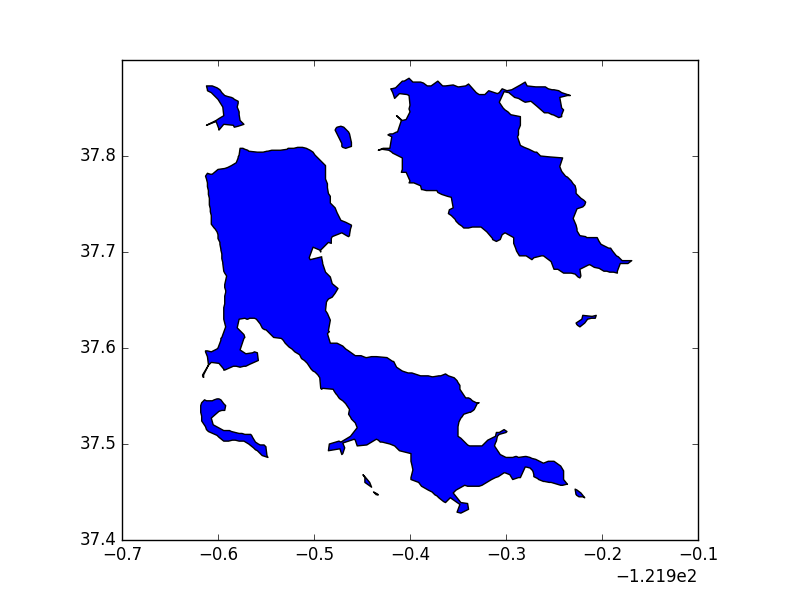

In [17]:
spd = gpd.GeoDataFrame({"geometry" : gpd.GeoSeries(poly)})
f = spd.plot()
display(f.figure)

In [18]:
test_roads = gpd.read_file('/dbfs/FileStore/tables/Roads/Roads_BayArea.shp')
exclude_catg = ['service', 'footway' , 'bridleway', 'cycleway',  'path', 'steps',  'track', 'track_grade1', 'track_grade2', 'track_grade3', 'track_grade4', 'track_grade5', 'residential']
test_roads = test_roads.loc[~test_roads["fclass"].isin(exclude_catg)]

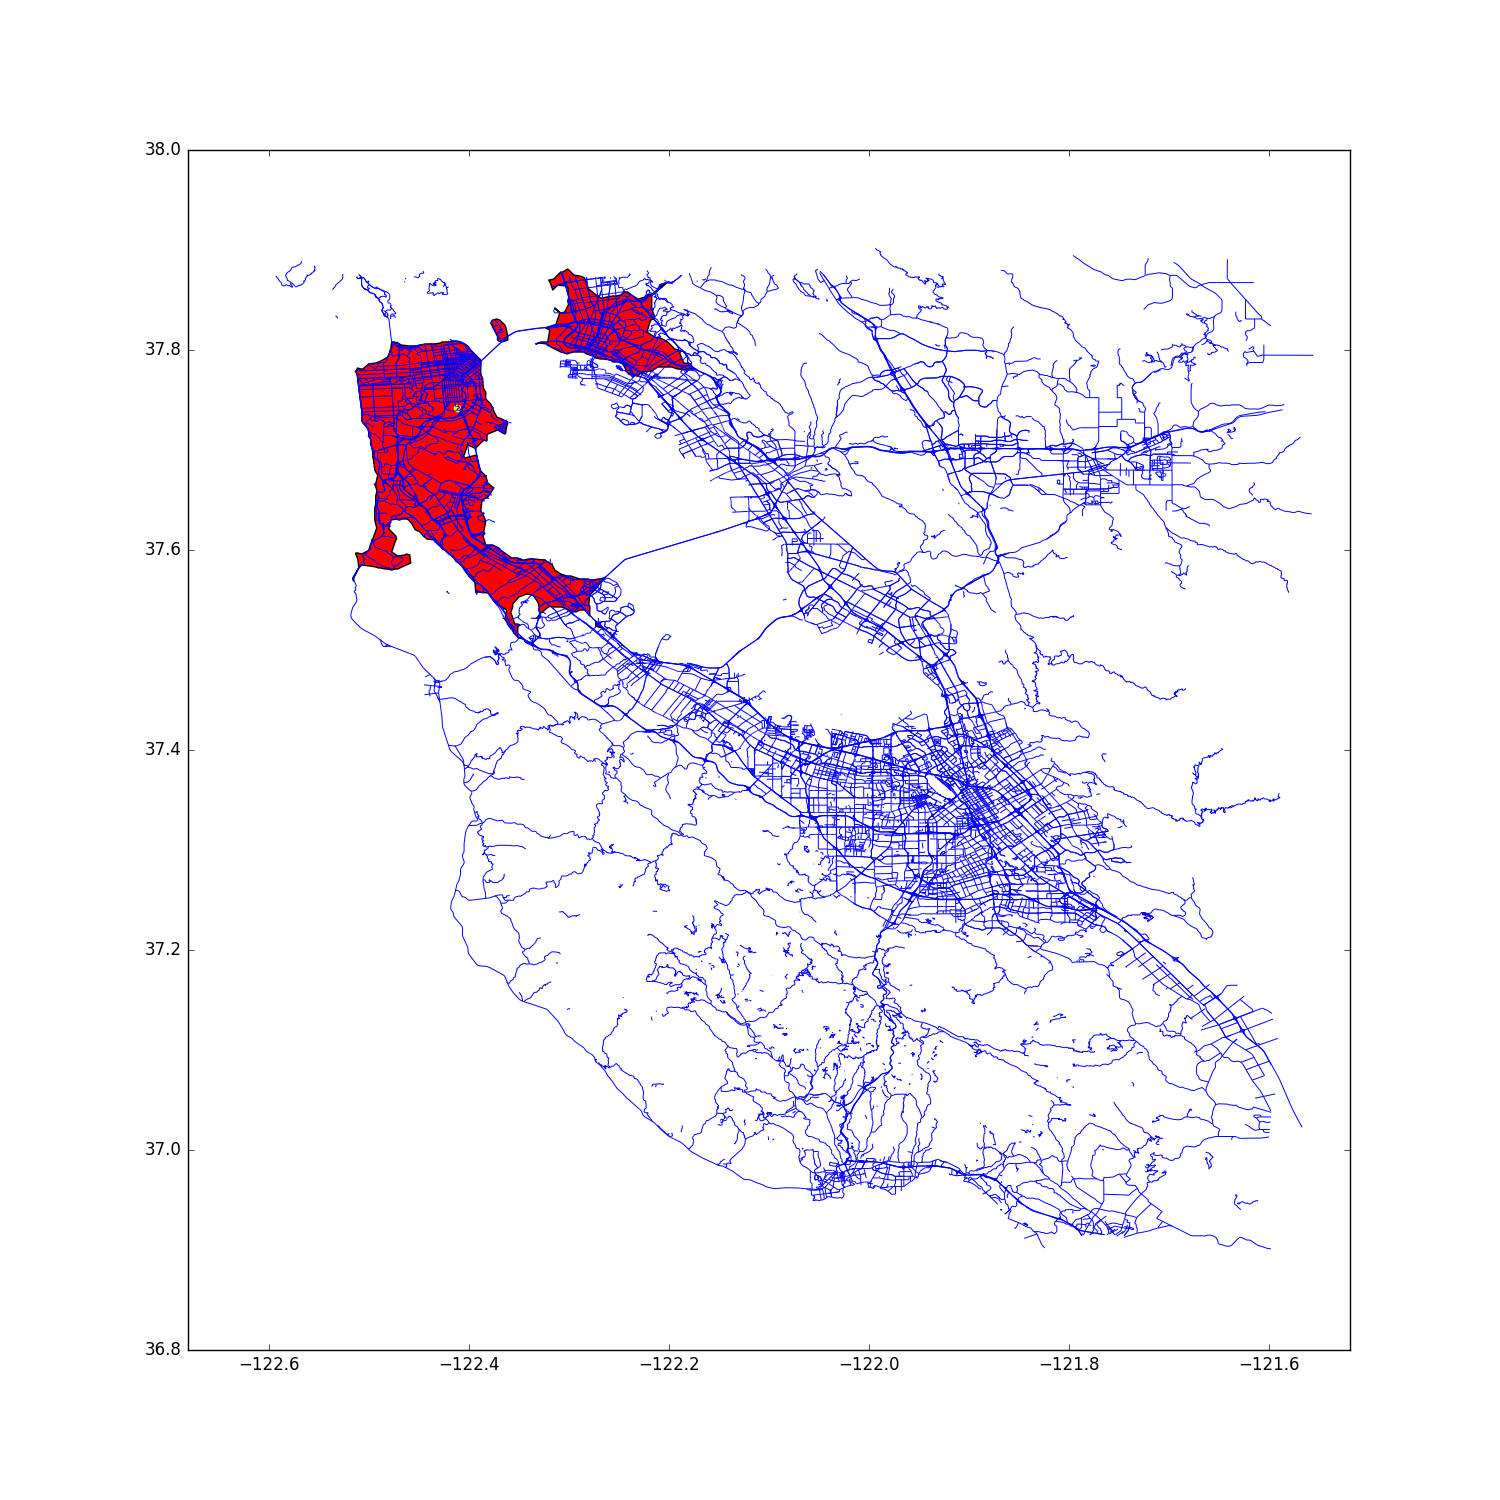

In [19]:
g, ax = plt.subplots(1, figsize=(15,15))
ax = test_roads.plot(color='blue', ax=ax, linewidth = 0.7)
lims = plt.axis('equal')
spd.plot(ax=ax, color='red')
pt_gdf = gpd.GeoDataFrame(geometry=[Point(center)])
pt_gdf.plot(ax = ax, color = 'yellow')
display(g.figure)

In [20]:
df = spark.createDataFrame(location_time_matrix)
display(df)

dst_lat,dst_lon,time
37.423,-122.227,29.0
37.428,-122.247,29.0
37.429,-122.251,29.0
37.429,-122.25,29.0
37.429,-122.248,29.0
37.43,-122.249,29.0
37.43,-122.248,29.0
37.432,-122.247,29.0
37.432,-122.239,28.0
37.433,-122.246,29.0
